<a href="https://colab.research.google.com/github/IqbalLx/Data-Science-Project/blob/master/Analisa_Pendapatan%20(TA_SanberCode_DS_Bootcamp).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing the Dataset

In [0]:
from google.colab import files
data = files.upload()

Saving sanbercode-data-science.zip to sanbercode-data-science.zip


In [0]:
import zipfile

filename = [key for key in data.keys()][0]
zip_ref = zipfile.ZipFile(filename)
zip_ref.extractall()
zip_ref.close()

# Dataset Overview

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df_raw = pd.read_csv('Pendapatan.csv')
df_test_raw = pd.read_csv('Pendapatan_test.csv')

df = df_raw.copy()
df_test = df_test_raw.copy()

df.head()

,id,Umur,Kelas Pekerja,Berat Akhir,Pendidikan,Jmlh Tahun Pendidikan,Status Perkawinan,Pekerjaan,Jenis Kelamin,Keuntungan Kapital,Kerugian Capital,Jam per Minggu,Gaji
0,27247,59,Pemerintah Negara,139616,Master,14,Menikah,Ekesekutif Managerial,Laki2,0.0,0.0,50.0,1
1,1640,52,Wiraswasta,158993,SMA,9,Cerai,Servis Lainnya,Perempuan,0.0,0.0,38.0,0
2,45206,52,Pekerja Bebas Bukan Perusahan,284648,SMA,9,Cerai,Ekesekutif Managerial,Perempuan,0.0,0.0,99.0,1
3,16154,45,Wiraswasta,132847,SMA,9,Belum Pernah Menikah,Pembersih,Perempuan,0.0,0.0,40.0,0
4,43023,28,Wiraswasta,103432,SMA,9,Belum Pernah Menikah,Supir,Laki2,0.0,0.0,45.0,1


In [0]:
df_test.head()

,id,Umur,Kelas Pekerja,Berat Akhir,Pendidikan,Jmlh Tahun Pendidikan,Status Perkawinan,Pekerjaan,Jenis Kelamin,Keuntungan Kapital,Kerugian Capital,Jam per Minggu
0,47933,30,Pemerintah Lokal,99761,D4,11,Cerai,Pemuka Agama,Perempuan,0.0,0.0,40.0
1,44213,28,Wiraswasta,202206,SMA,9,Menikah,Mesin Inspeksi,Laki2,0.0,0.0,50.0
2,20823,34,Pemerintah Provinsi,199934,Pendidikan Tinggi,10,Menikah,Pemuka Agama,Laki2,0.0,0.0,40.0
3,40565,51,Wiraswasta,373448,Pendidikan Tinggi,10,Menikah,Ekesekutif Managerial,Laki2,0.0,28028000.0,40.0
4,9860,20,?,144685,Pendidikan Tinggi,10,Belum Pernah Menikah,?,Perempuan,0.0,22428000.0,40.0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38393 entries, 0 to 38392
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     38393 non-null  int64  
 1   Umur                   38393 non-null  int64  
 2   Kelas Pekerja          38393 non-null  object 
 3   Berat Akhir            38393 non-null  int64  
 4   Pendidikan             38393 non-null  object 
 5   Jmlh Tahun Pendidikan  38393 non-null  int64  
 6   Status Perkawinan      38393 non-null  object 
 7   Pekerjaan              38393 non-null  object 
 8   Jenis Kelamin          38393 non-null  object 
 9   Keuntungan Kapital     38393 non-null  float64
 10  Kerugian Capital       38393 non-null  float64
 11  Jam per Minggu         38393 non-null  float64
 12  Gaji                   38393 non-null  int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 3.8+ MB


In [0]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f'))).transpose()

,count,mean,std,min,25%,50%,75%,max
id,38393.000000,24015.248535,13872.059919,0.000000,11989.000000,24050.000000,36031.000000,47991.000000
Umur,38393.000000,38.673925,13.694678,17.000000,28.000000,37.000000,48.000000,90.000000
Berat Akhir,38393.000000,189723.756284,105576.445288,12285.000000,117751.000000,178385.000000,237630.000000,1490400.000000
Jmlh Tahun Pendidikan,38393.000000,10.082828,2.574543,1.000000,9.000000,10.000000,12.000000,16.000000
Keuntungan Kapital,38393.000000,15186589.065715,104437326.454833,0.000000,0.000000,0.000000,0.000000,1399986000.000000
Kerugian Capital,38393.000000,1212665.173339,5613944.895757,0.000000,0.000000,0.000000,0.000000,60984000.000000
Jam per Minggu,38393.000000,40.440627,12.382695,1.000000,40.000000,40.000000,45.000000,99.000000
Gaji,38393.000000,0.239497,0.426782,0.000000,0.000000,0.000000,0.000000,1.000000


In [0]:
df.nunique()

id                       38393
Umur                        73
Kelas Pekerja                9
Berat Akhir              24396
Pendidikan                  16
Jmlh Tahun Pendidikan       16
Status Perkawinan            6
Pekerjaan                   15
Jenis Kelamin                2
Keuntungan Kapital         120
Kerugian Capital            96
Jam per Minggu              95
Gaji                         2
dtype: int64

# Data Preprocess

In [0]:
df.Pekerjaan.unique()

array(['Ekesekutif Managerial', 'Servis Lainnya', 'Pembersih', 'Supir',
       'Sales', 'Perbaikan Kerajinan', '?', 'Tech-support',
       'Pemuka Agama', 'Spesialis', 'Mesin Inspeksi', 'Petani', 'Penjaga',
       'Asisten Rumah Tangga', 'Tentara'], dtype=object)

I spot that missing values here is using ?, so I am gonna preprocess it before jump to EDA

In [0]:
df = df.apply(lambda s: np.where(s == '?', np.nan, s))
df_test = df_test.apply(lambda s: np.where(s == '?', np.nan, s))

# one of five first value in test data should now contain nan for ? value
df_test.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,id,Umur,Kelas Pekerja,Berat Akhir,Pendidikan,Jmlh Tahun Pendidikan,Status Perkawinan,Pekerjaan,Jenis Kelamin,Keuntungan Kapital,Kerugian Capital,Jam per Minggu
0,47933.0,30.0,Pemerintah Lokal,99761.0,D4,11.0,Cerai,Pemuka Agama,Perempuan,0.0,0.0,40.0
1,44213.0,28.0,Wiraswasta,202206.0,SMA,9.0,Menikah,Mesin Inspeksi,Laki2,0.0,0.0,50.0
2,20823.0,34.0,Pemerintah Provinsi,199934.0,Pendidikan Tinggi,10.0,Menikah,Pemuka Agama,Laki2,0.0,0.0,40.0
3,40565.0,51.0,Wiraswasta,373448.0,Pendidikan Tinggi,10.0,Menikah,Ekesekutif Managerial,Laki2,0.0,28028000.0,40.0
4,9860.0,20.0,NaN,144685.0,Pendidikan Tinggi,10.0,Belum Pernah Menikah,NaN,Perempuan,0.0,22428000.0,40.0


In [0]:
df.head()

,id,Umur,Kelas Pekerja,Berat Akhir,Pendidikan,Jmlh Tahun Pendidikan,Status Perkawinan,Pekerjaan,Jenis Kelamin,Keuntungan Kapital,Kerugian Capital,Jam per Minggu,Gaji
0,27247.0,59.0,Pemerintah Negara,139616.0,Master,14.0,Menikah,Ekesekutif Managerial,Laki2,0.0,0.0,50.0,1.0
1,1640.0,52.0,Wiraswasta,158993.0,SMA,9.0,Cerai,Servis Lainnya,Perempuan,0.0,0.0,38.0,0.0
2,45206.0,52.0,Pekerja Bebas Bukan Perusahan,284648.0,SMA,9.0,Cerai,Ekesekutif Managerial,Perempuan,0.0,0.0,99.0,1.0
3,16154.0,45.0,Wiraswasta,132847.0,SMA,9.0,Belum Pernah Menikah,Pembersih,Perempuan,0.0,0.0,40.0,0.0
4,43023.0,28.0,Wiraswasta,103432.0,SMA,9.0,Belum Pernah Menikah,Supir,Laki2,0.0,0.0,45.0,1.0


In [0]:
df.shape

(38393, 13)

In [0]:
df.isnull().sum()

id                          0
Umur                        0
Kelas Pekerja            2204
Berat Akhir                 0
Pendidikan                  0
Jmlh Tahun Pendidikan       0
Status Perkawinan           0
Pekerjaan                2210
Jenis Kelamin               0
Keuntungan Kapital          0
Kerugian Capital            0
Jam per Minggu              0
Gaji                        0
dtype: int64

In [0]:
df_test.shape

(9599, 12)

In [0]:
df_test.isnull().sum()

id                         0
Umur                       0
Kelas Pekerja            552
Berat Akhir                0
Pendidikan                 0
Jmlh Tahun Pendidikan      0
Status Perkawinan          0
Pekerjaan                554
Jenis Kelamin              0
Keuntungan Kapital         0
Kerugian Capital           0
Jam per Minggu             0
dtype: int64

# Exploratory Data Analysis and Feature Engineering

In [0]:
df.sample(5)

,id,Umur,Kelas Pekerja,Berat Akhir,Pendidikan,Jmlh Tahun Pendidikan,Status Perkawinan,Pekerjaan,Jenis Kelamin,Keuntungan Kapital,Kerugian Capital,Jam per Minggu,Gaji
33107,37281.0,50.0,Pemerintah Lokal,237868.0,Master,14.0,Menikah,Spesialis,Laki2,0.0,0.0,40.0,0.0
34542,20528.0,36.0,Wiraswasta,111128.0,SMA,9.0,Berpisah,Perbaikan Kerajinan,Laki2,0.0,0.0,40.0,0.0
3370,32196.0,19.0,Wiraswasta,355712.0,Pendidikan Tinggi,10.0,Belum Pernah Menikah,Sales,Perempuan,0.0,0.0,25.0,0.0
2924,30477.0,44.0,Wiraswasta,215304.0,Sarjana,13.0,Menikah,Spesialis,Laki2,0.0,0.0,45.0,1.0
8831,28799.0,41.0,Wiraswasta,168324.0,Pendidikan Tinggi,10.0,Menikah,Pemuka Agama,Perempuan,0.0,0.0,40.0,1.0


In [0]:
df.columns

Index(['id', 'Umur', 'Kelas Pekerja', 'Berat Akhir', 'Pendidikan',
       'Jmlh Tahun Pendidikan', 'Status Perkawinan', 'Pekerjaan',
       'Jenis Kelamin', 'Keuntungan Kapital', 'Kerugian Capital',
       'Jam per Minggu', 'Gaji'],
      dtype='object')

So this data contain categorical and continous value. Categorical including Jenis kelamin, kelas pekerja, pendidikan, status perkawinan, and pekerjaan. The rest is continous value. I want to inspect this categorical value first

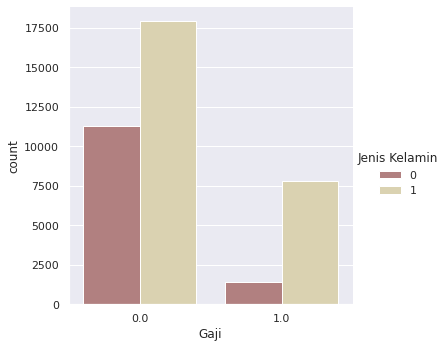

In [0]:
df['Jenis Kelamin'] = np.where(df['Jenis Kelamin'] == 'Laki2', 1, 0)
df_test['Jenis Kelamin'] = np.where(df_test['Jenis Kelamin'] == 'Laki2', 1, 0)

sns.catplot(x='Gaji', kind='count', hue='Jenis Kelamin', palette='pink', data=df)

So I notice that this columns is imbalanced, where people with Gaji <= 5M more than the people with Gaji >= 5M, also Male data is more than Female

In [0]:
df['Kelas Pekerja'].unique()

array(['Pemerintah Negara', 'Wiraswasta', 'Pekerja Bebas Bukan Perusahan',
       nan, 'Pemerintah Lokal', 'Pekerja Bebas Perusahaan',
       'Pemerintah Provinsi', 'Tanpa di Bayar', 'Tidak Pernah Bekerja'],
      dtype=object)

In [0]:
df['Pekerjaan'].unique()

array(['Ekesekutif Managerial', 'Servis Lainnya', 'Pembersih', 'Supir',
       'Sales', 'Perbaikan Kerajinan', nan, 'Tech-support',
       'Pemuka Agama', 'Spesialis', 'Mesin Inspeksi', 'Petani', 'Penjaga',
       'Asisten Rumah Tangga', 'Tentara'], dtype=object)

<Figure size 864x864 with 0 Axes>

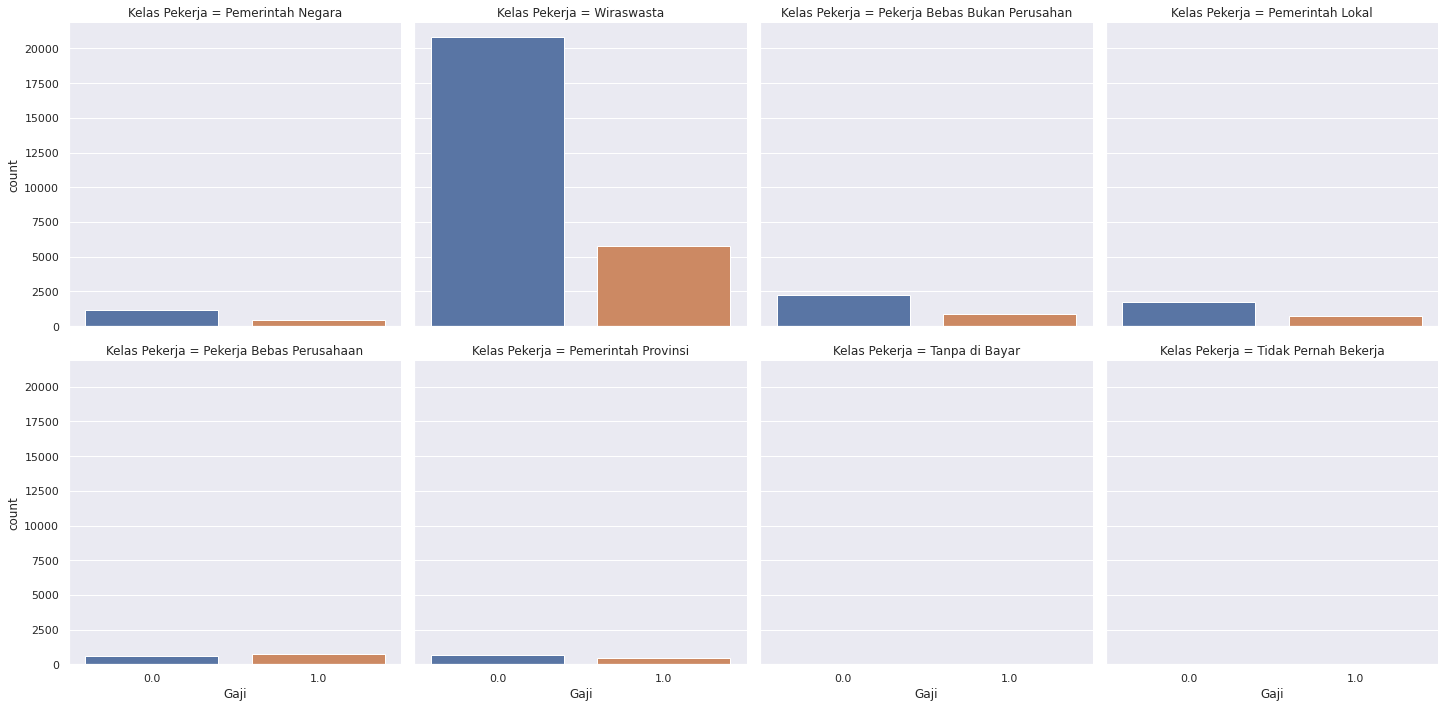

In [0]:
plt.figure(figsize=(12, 12))
sns.catplot(x='Gaji', kind='count', col='Kelas Pekerja', col_wrap=4, data=df)

Here I decided to use Kelas Pekerja to make our data more general, because if we make model that takes specialize job title, it'll hard to predict the job salary that that the model never see the title before, so I think that by using more general term aka Kelas Pekerja it's possible for model to predict job salary for any job, because it's still has same class aka Kelas Pekerja nya masih sama.
Also if I one hot encoded Pekerjaan, it'll increasing a lot of the dimensionality, and there is a curse of high dimensionality :D

Here I wanna categorize the Kelas Pekerja column into 4 category:
1. Pemerintah = Pemerintah Negara, Lokal and Provinsi
2. Wiraswasta (because it's the largest class)
3. Freelance = Pekerja lepas perusahaan and bukan perusahaan
4. Not work = Tanpa bayaran and Tidak bekerja

Then I'll one hot encode that later in data cleaning

In [0]:
mapping = {
    'Pemerintah Negara': 'Pemerintah',
    'Pekerja Bebas Bukan Perusahan': 'Freelance',
    'Pemerintah Lokal': 'Pemerintah',
    'Pekerja Bebas Perusahaan': 'Freelance',
    'Pemerintah Provinsi': 'Pemerintah',
    'Tanpa di Bayar': 'Tidak bekerja',
    'Tidak Pernah Bekerja': 'Tidak bekerja',
    'Wiraswasta': 'Wiraswasta',
    np.nan : np.nan,
}
df['Kelas Pekerja Map'] = df['Kelas Pekerja'].map(mapping)
df['Kelas Pekerja Map'].unique()

array(['Pemerintah', 'Wiraswasta', 'Freelance', nan, 'Tidak bekerja'],
      dtype=object)

In [0]:
df.drop(['Kelas Pekerja', 'Pekerjaan'], axis=1, inplace=True)

In [0]:
#Do the same with test dataset
df_test['Kelas Pekerja Map'] = df_test['Kelas Pekerja'].map(mapping)
df_test.drop(['Kelas Pekerja', 'Pekerjaan'], axis=1, inplace=True)

df_test['Kelas Pekerja Map'].unique()

array(['Pemerintah', 'Wiraswasta', nan, 'Freelance', 'Tidak bekerja'],
      dtype=object)

In [0]:
df['Status Perkawinan'].unique()

array(['Menikah', 'Cerai', 'Belum Pernah Menikah', 'Berpisah',
       'Menikah LDR', 'Janda'], dtype=object)

There are inconsistency in the value Cerai, Berpisah and Janda is mean the same, also Menikah and Menikah LDR is just the same. I'll map it again into just 2 columns Menikah, Berpisah and Belum pernah menikah

<Figure size 576x576 with 0 Axes>

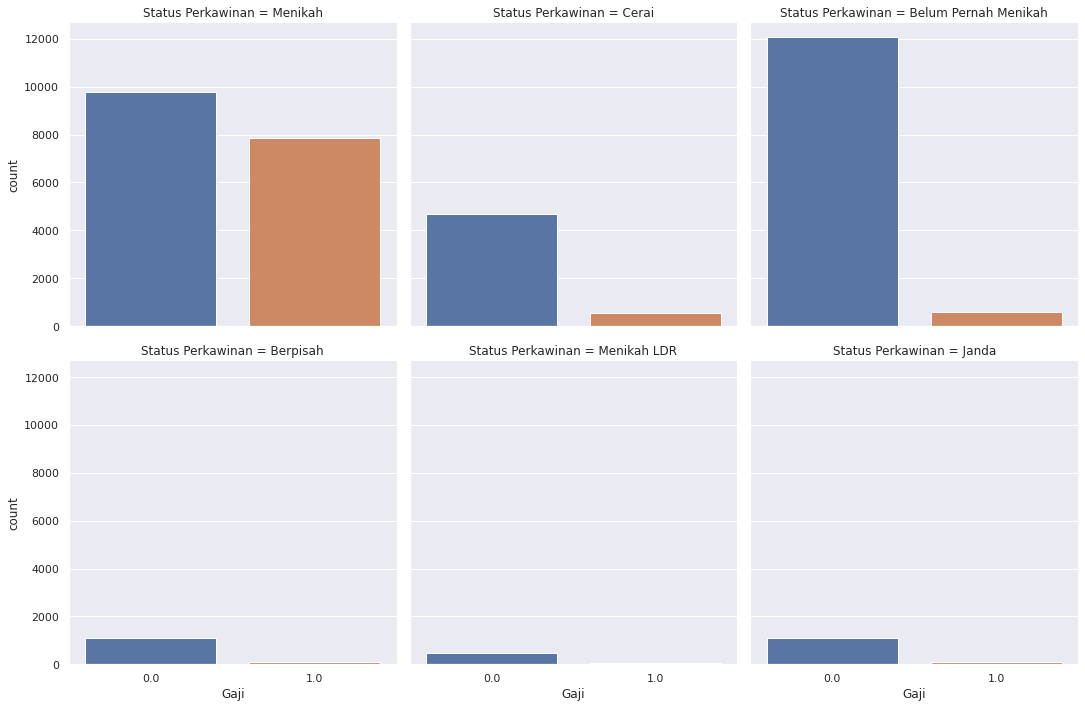

In [0]:
plt.figure(figsize=(8, 8))
sns.catplot(x='Gaji', kind='count', col='Status Perkawinan', col_wrap=3, data=df)

In [0]:
mapp = {
    'Menikah' : 'Menikah',
    'Cerai' : 'Berpisah',
    'Belum Pernah Menikah' : 'Belum pernah menikah',
    'Berpisah' : 'Berpisah',
    'Menikah LDR' : 'Menikah',
    'Janda' : 'Berpisah',
}
df['Status Perkawinan Map'] = df['Status Perkawinan'].map(mapp)
df.drop(['Status Perkawinan'], axis=1, inplace=True)

df['Status Perkawinan Map'].unique()

array(['Menikah', 'Berpisah', 'Belum pernah menikah'], dtype=object)

In [0]:
#Do the same in test data
df_test['Status Perkawinan Map'] = df_test['Status Perkawinan'].map(mapp)
df_test.drop(['Status Perkawinan'], axis=1, inplace=True)

df_test['Status Perkawinan Map'].unique()

array(['Berpisah', 'Menikah', 'Belum pernah menikah'], dtype=object)

In [0]:
df['Pendidikan'].unique()

array(['Master', 'SMA', 'Sarjana', '10th', 'Pendidikan Tinggi', '11th',
       'D4', 'D3', 'Sekolah Professional', '9th', '7th-8th', 'Doktor',
       '1st-4th', '5th-6th', '12th', 'SD'], dtype=object)

In [0]:
df[['Pendidikan', 'Jmlh Tahun Pendidikan']].sample(10)

,Pendidikan,Jmlh Tahun Pendidikan
29684,Sarjana,13.0
15394,D4,11.0
25932,Sarjana,13.0
2279,12th,8.0
16374,SMA,9.0
22644,SMA,9.0
37643,Sarjana,13.0
28144,SMA,9.0
31764,11th,7.0
13967,SMA,9.0


I confused with what is '1st-4th', '5th-6th', '9th', '7th-8th', '12th' means. I think that it's a grade, so 9th grade equal SMP kelas 3, which is 9th year of school respectively, but the columns Tahun show it's 5 year of study, which means only SD kelas 5.

Gonna check the correlation with Gaji

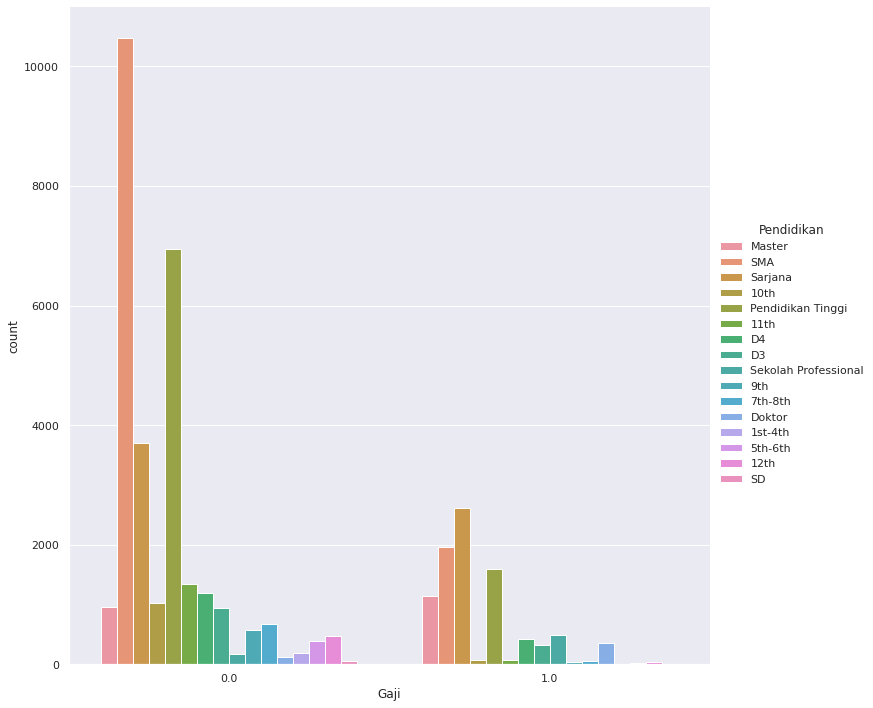

In [0]:
sns.catplot(x='Gaji', kind='count', hue='Pendidikan', data=df, height=10)
plt.show()

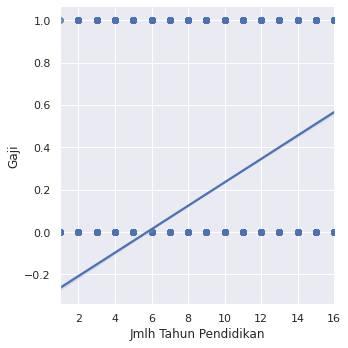

In [0]:
sns.lmplot('Jmlh Tahun Pendidikan', 'Gaji', palette='inferno_r', data=df)
plt.show()

It's clear that the years of study positively correlated with the amount of salary, I decided to not using Pendidikan column, because it's categorical that hard to encode, also there are some inconsitency with years of study, so I am just using Tahun pendidikan 

Now lets move on Numerical values, first gonna check the correlation

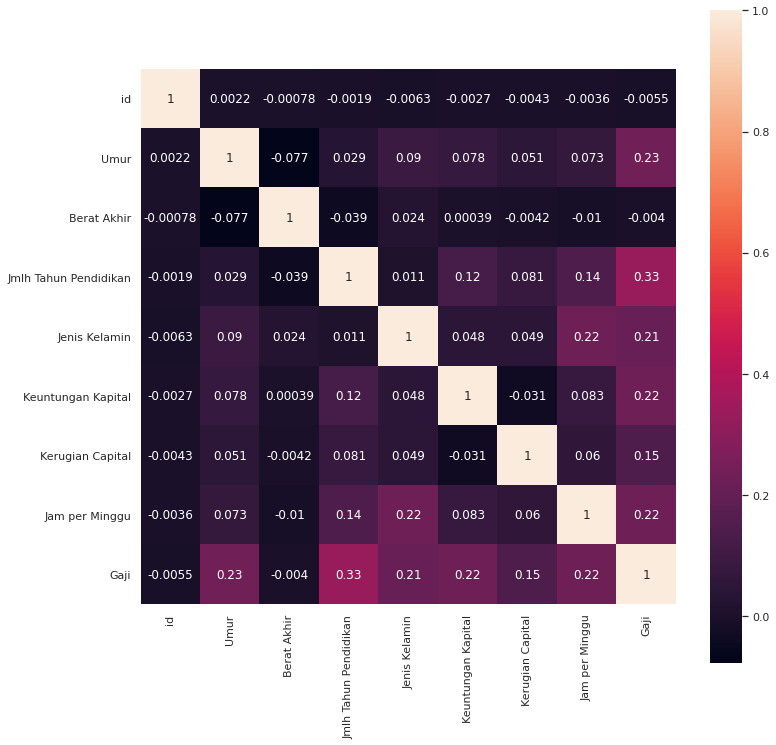

In [0]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), square=True, annot=True)

In [0]:
df.corr()['Gaji'].sort_values(ascending=False)

Gaji                     1.000000
Jmlh Tahun Pendidikan    0.333691
Umur                     0.231462
Jam per Minggu           0.224611
Keuntungan Kapital       0.223230
Jenis Kelamin            0.211371
Kerugian Capital         0.145710
Berat Akhir             -0.003956
id                      -0.005507
Name: Gaji, dtype: float64

In [0]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f'))).transpose()

,count,mean,std,min,25%,50%,75%,max
id,38393.000000,24015.248535,13872.059919,0.000000,11989.000000,24050.000000,36031.000000,47991.000000
Umur,38393.000000,38.673925,13.694678,17.000000,28.000000,37.000000,48.000000,90.000000
Berat Akhir,38393.000000,189723.756284,105576.445288,12285.000000,117751.000000,178385.000000,237630.000000,1490400.000000
Jmlh Tahun Pendidikan,38393.000000,10.082828,2.574543,1.000000,9.000000,10.000000,12.000000,16.000000
Jenis Kelamin,38393.000000,0.669601,0.470363,0.000000,0.000000,1.000000,1.000000,1.000000
Keuntungan Kapital,38393.000000,15186589.065715,104437326.454833,0.000000,0.000000,0.000000,0.000000,1399986000.000000
Kerugian Capital,38393.000000,1212665.173339,5613944.895757,0.000000,0.000000,0.000000,0.000000,60984000.000000
Jam per Minggu,38393.000000,40.440627,12.382695,1.000000,40.000000,40.000000,45.000000,99.000000
Gaji,38393.000000,0.239497,0.426782,0.000000,0.000000,0.000000,0.000000,1.000000


Standard Deviation for Berat Akhir, Keuntungan Kapital and Kerugian Kapital is so large, consider doing some scaling in data cleanng section. Because I cant remove it, it's give some value to our data

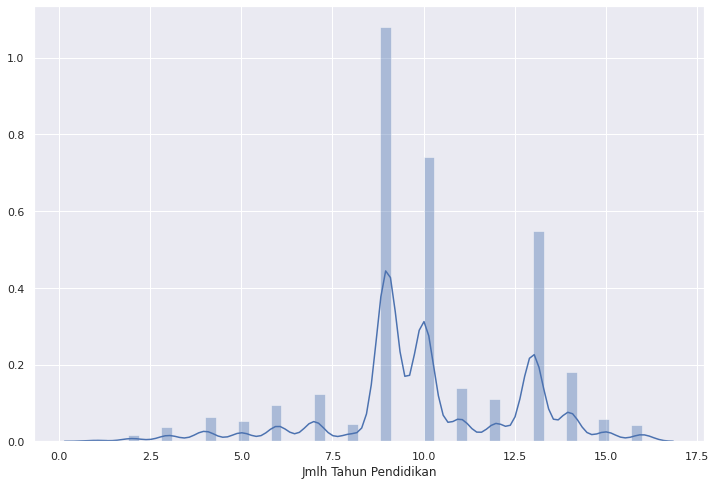

In [0]:
plt.figure(figsize=(12, 8))
sns.distplot(df['Jmlh Tahun Pendidikan'])

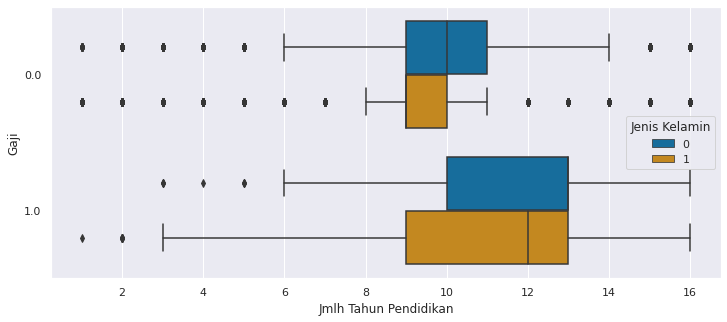

In [0]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='Jmlh Tahun Pendidikan', y='Gaji', hue='Jenis Kelamin', data=df, orient='h', palette='colorblind')

It's clear that more years of study resulted in higher salary, no matter the gender. Also there are some outliers, but I think it's not much, so we can go with that

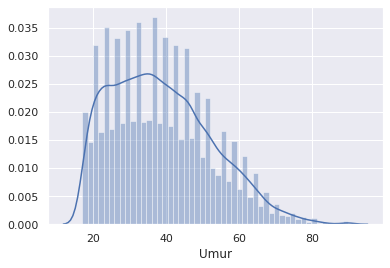

In [0]:
sns.distplot(df.Umur)

It's right skewed, but since there is no missing value on that, it's nothing I can do about it

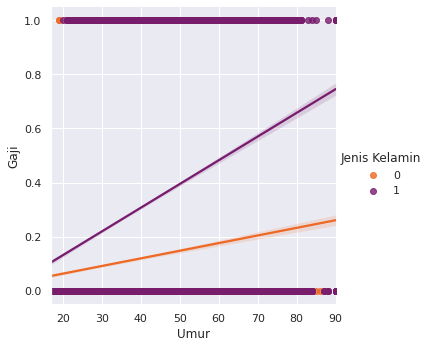

In [0]:
sns.lmplot(x='Umur', y='Gaji', hue='Jenis Kelamin', palette='inferno_r', data=df)

Also it's clearly indicates that older you are, higher your salary, it's related with experience of that person, no matter the gender, but it seems that male still have higher salary

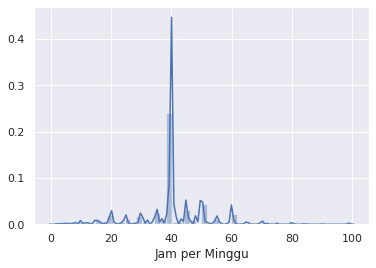

In [0]:
sns.distplot(df['Jam per Minggu'])

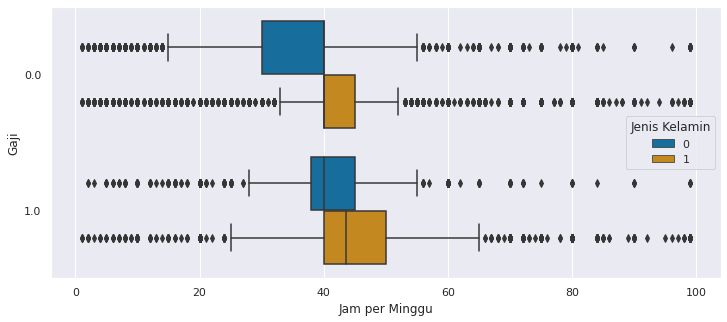

In [0]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='Jam per Minggu', y='Gaji', hue='Jenis Kelamin', data=df, orient='h', palette='colorblind')

That is so many outliers, but I still think it's OK because most people is Wiraswasta, so their working time is vary a lot, and it's matter for prediction because more time they spend for work, higher the salary they got

In [0]:
df.columns

Index(['id', 'Umur', 'Berat Akhir', 'Pendidikan', 'Jmlh Tahun Pendidikan',
       'Jenis Kelamin', 'Keuntungan Kapital', 'Kerugian Capital',
       'Jam per Minggu', 'Gaji', 'Kelas Pekerja Map', 'Status Perkawinan Map'],
      dtype='object')

In [0]:
df.drop(['id', 'Pendidikan'], axis=1, inplace=True)
df_test.drop(['id', 'Pendidikan'], axis=1, inplace=True)

In [0]:
df[['Berat Akhir', 'Keuntungan Kapital', 'Kerugian Capital']] = StandardScaler().fit_transform(df[['Berat Akhir', 'Keuntungan Kapital', 'Kerugian Capital']])
df_test[['Berat Akhir', 'Keuntungan Kapital', 'Kerugian Capital']] = StandardScaler().fit_transform(df_test[['Berat Akhir', 'Keuntungan Kapital', 'Kerugian Capital']])

In [0]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Umur,38393.0,3.867392e+01,13.694678,17.000000,28.000000,37.000000,48.000000,90.000000
Berat Akhir,38393.0,-7.884888e-17,1.000013,-1.680688,-0.681721,-0.107400,0.453765,12.319918
Jmlh Tahun Pendidikan,38393.0,1.008283e+01,2.574543,1.000000,9.000000,10.000000,12.000000,16.000000
Jenis Kelamin,38393.0,6.696012e-01,0.470363,0.000000,0.000000,1.000000,1.000000,1.000000
Keuntungan Kapital,38393.0,2.308225e-15,1.000013,-0.145415,-0.145415,-0.145415,-0.145415,13.259794
Kerugian Capital,38393.0,8.737386e-16,1.000013,-0.216012,-0.216012,-0.216012,-0.216012,10.647079
Jam per Minggu,38393.0,4.044063e+01,12.382695,1.000000,40.000000,40.000000,45.000000,99.000000
Gaji,38393.0,2.394968e-01,0.426782,0.000000,0.000000,0.000000,0.000000,1.000000


In [0]:
df.corr()['Gaji'].sort_values(ascending=False)

Gaji                     1.000000
Jmlh Tahun Pendidikan    0.333691
Umur                     0.231462
Jam per Minggu           0.224611
Keuntungan Kapital       0.223230
Jenis Kelamin            0.211371
Kerugian Capital         0.145710
Berat Akhir             -0.003956
Name: Gaji, dtype: float64

In [0]:
df.isnull().sum()

Umur                        0
Berat Akhir                 0
Jmlh Tahun Pendidikan       0
Jenis Kelamin               0
Keuntungan Kapital          0
Kerugian Capital            0
Jam per Minggu              0
Gaji                        0
Kelas Pekerja Map        2204
Status Perkawinan Map       0
dtype: int64

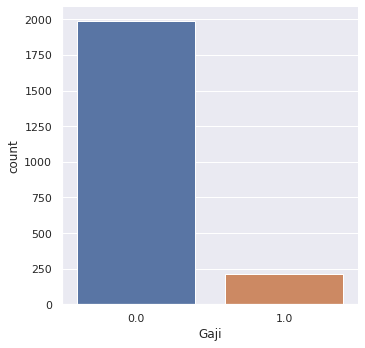

In [0]:
sns.catplot(x='Gaji', kind='count', data=df[df['Kelas Pekerja Map'].isnull()])

It's quite a lot of missing data that the graph shows it looks like another category, so I'll impute it with Lainnya category

In [0]:
df['Kelas Pekerja Map'] = df['Kelas Pekerja Map'].fillna('Lainnya')
df_test['Kelas Pekerja Map'] = df_test['Kelas Pekerja Map'].fillna('Lainnya')

Lets One hot encode all the categorical variables

In [0]:
df_clean = pd.get_dummies(df, columns=['Kelas Pekerja Map', 'Status Perkawinan Map'], drop_first=True)
df_test_clean = pd.get_dummies(df_test, columns=['Kelas Pekerja Map', 'Status Perkawinan Map'], drop_first=True)

df_clean.head()

,Umur,Berat Akhir,Jmlh Tahun Pendidikan,Jenis Kelamin,Keuntungan Kapital,Kerugian Capital,Jam per Minggu,Gaji,Kelas Pekerja Map_Lainnya,Kelas Pekerja Map_Pemerintah,Kelas Pekerja Map_Tidak bekerja,Kelas Pekerja Map_Wiraswasta,Status Perkawinan Map_Berpisah,Status Perkawinan Map_Menikah
0,59.0,-0.474617,14.0,1,-0.145415,-0.216012,50.0,1.0,0,1,0,0,0,1
1,52.0,-0.291080,9.0,0,-0.145415,-0.216012,38.0,0.0,0,0,0,1,1,0
2,52.0,0.899116,9.0,0,-0.145415,-0.216012,99.0,1.0,0,0,0,0,1,0
3,45.0,-0.538733,9.0,0,-0.145415,-0.216012,40.0,0.0,0,0,0,1,0,0
4,28.0,-0.817350,9.0,1,-0.145415,-0.216012,45.0,1.0,0,0,0,1,0,0


#Predictive Modeling

In [0]:
X = df_clean.drop(['Gaji'], axis=1)
y = df_clean['Gaji']

In [0]:
params={
 "learning_rate"    : [0.1, 0.01, 0.001] ,
 "max_depth"        : [2, 4, 5, 7, 10],
 "min_child_weight" : [ 1, 3, 5, 7],
 "gamma"            : [0.01, 0.1, 0.3 , 0.5, 1, 1.5, 2],
 "colsample_bytree" : [ 0.3, 0.4, 0.5, 0.8, 1.0],
 'reg_alpha'        : [0.0, 0.5, 1.0],
 'reg_lambda'       : [1, 1.5, 2, 3, 4, 4.5],
 'n_estimators'     : [100, 250, 500, 1000]
}

In [0]:
model = XGBClassifier()
random = RandomizedSearchCV(model, param_distributions=params, scoring='roc_auc',
                            cv=5, verbose=3, random_state=40)
random.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] reg_lambda=1, reg_alpha=1.0, n_estimators=250, min_child_weight=3, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  reg_lambda=1, reg_alpha=1.0, n_estimators=250, min_child_weight=3, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0, score=0.919, total=   3.4s
[CV] reg_lambda=1, reg_alpha=1.0, n_estimators=250, min_child_weight=3, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV]  reg_lambda=1, reg_alpha=1.0, n_estimators=250, min_child_weight=3, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0, score=0.921, total=   2.6s
[CV] reg_lambda=1, reg_alpha=1.0, n_estimators=250, min_child_weight=3, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


[CV]  reg_lambda=1, reg_alpha=1.0, n_estimators=250, min_child_weight=3, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0, score=0.915, total=   2.6s
[CV] reg_lambda=1, reg_alpha=1.0, n_estimators=250, min_child_weight=3, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 
[CV]  reg_lambda=1, reg_alpha=1.0, n_estimators=250, min_child_weight=3, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0, score=0.910, total=   2.6s
[CV] reg_lambda=1, reg_alpha=1.0, n_estimators=250, min_child_weight=3, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 
[CV]  reg_lambda=1, reg_alpha=1.0, n_estimators=250, min_child_weight=3, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0, score=0.915, total=   2.6s
[CV] reg_lambda=4.5, reg_alpha=1.0, n_estimators=250, min_child_weight=7, max_depth=4, learning_rate=0.1, gamma=1.5, colsample_bytree=0.8 
[CV]  reg_lambda=4.5, reg_alpha=1.0, n_estimators=250, min_child_weight=7, max_depth=4, lear

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.8,
                                                             1.0],
                             

In [0]:
random.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=2,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
random.best_params_

{'colsample_bytree': 0.4,
 'gamma': 2,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 250,
 'reg_alpha': 0.5,
 'reg_lambda': 1}

In [0]:
best_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=2,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

score = cross_val_score(best_model, X, y, scoring='roc_auc', cv=10)
print(score)
print('-'*40)
print(score.mean())

[0.92479582 0.92589767 0.92769636 0.92304411 0.92458499 0.91881512
 0.91211971 0.91986301 0.91937521 0.92164894]
----------------------------------------
0.9217840954069738


In [0]:
best_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=2,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

rf_params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [0]:
rf_model = RandomForestClassifier()
random_rf = RandomizedSearchCV(rf_model, param_distributions=rf_params,
                               cv=5, verbose=3, random_state=40)
random_rf.fit(X, y)
print('-'*50)
random_rf.best_estimator_
print('-'*50)
random_rf.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, score=0.859, total= 1.1min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, score=0.858, total= 1.1min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, score=0.856, total= 1.1min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, score=0.854, total= 1.1min
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, score=0.856, total= 1.0min
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=False, score=0.834, total=  44.4s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto,

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 32.8min finished


--------------------------------------------------
--------------------------------------------------


{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 800}

In [0]:
random_rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
best_model_rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

score_rf = cross_val_score(best_model_rf, X, y, scoring='roc_auc', cv=10)
print(score_rf)
print('-'*40)
print(score_rf.mean())

[0.91544521 0.91312816 0.91648861 0.91496734 0.91270518 0.90763598
 0.90188151 0.91044726 0.90969655 0.91027882]
----------------------------------------
0.9112674614299715


In [0]:
best_model_rf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)